In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad =  1.0 * out.grad

    out._backward = _backward
    return out
  
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad

    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad

    self._backward = _backward
    return out


SyntaxError: invalid syntax (3487257106.py, line 5)

In [88]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(4.1, label='c')
d = Value(-0.1, label='d')
e = a + b; e.label = 'e'
f = b * c; f.label = 'f'
g = Value(-1.5, label='g')
h = f * g; h.label='h'

# o = a + b * c * d; o.label='out'
o = e + h; o.label='L'
o

Value(data=17.45)

In [84]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
        
  build(root)

  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))

    dot.node(name = uid, label="{ %s | data %.2f | grad %.2f }" % (n.label, n.data, n.grad,), shape='record', tooltip=n.label)
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)
  
  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

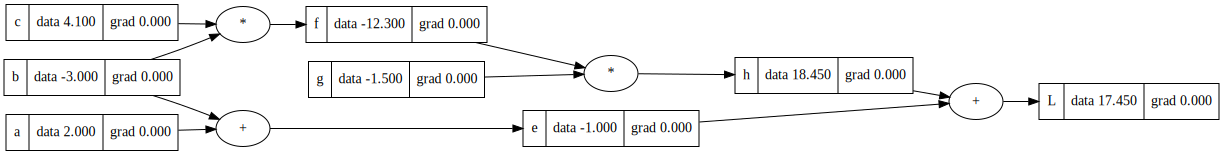

In [86]:
draw_dot(o)